# Rapid giant impact simulations

This notebook illustrates the typical use case of the giant impact emulator model.

We start by initializing many overly packed planetary systems with REBOUND, each containing ten equally spaced planets with equal masses. Initial eccentricities, inclinations, and orbital angles are all drawn randomly. This is done as follows:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from spock import GiantImpactPhaseEmulator
import rebound
%matplotlib inline

def init_sim(N_pl=10, m=1e-5, P_ratio=1.15, sigma_e=0.01, sigma_inc=0.01):
    sim = rebound.Simulation()
    sim.add(m=1.)
    for i in range(N_pl):
        # draw random eccentricities and inclinations
        rand_e = np.random.rayleigh(sigma_e)
        rand_inc = np.random.rayleigh(sigma_inc)
        
        # draw random orbital angles
        rand_l = np.random.uniform(0.0, 2*np.pi)
        rand_omega = np.random.uniform(0.0, 2*np.pi)
        rand_Omega = np.random.uniform(0.0, 2*np.pi)
        sim.add(m=m, P=P_ratio**i, e=rand_e, inc=rand_inc, l=rand_l, omega=rand_omega, Omega=rand_Omega)
        
    return sim

In [2]:
initial_conditions = []
for _ in range(50):
    initial_conditions.append(init_sim())

We can visualize the initial conditions using REBOUND's OrbitPlot functionality:

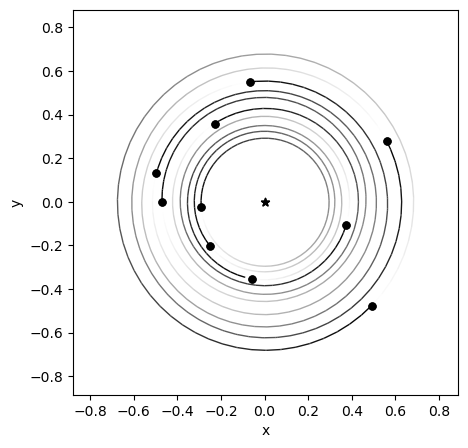

In [3]:
rebound.OrbitPlot(initial_conditions[0])

Next, we use the giant impact emulator model to predict the states of these systems after a billion orbits (tmax = $10^9$) of dynamical evolution. To get updates on the prediction progress, we use the verbose printing option:

In [4]:
emulator = GiantImpactPhaseEmulator()
final_states = emulator.predict(initial_conditions, tmaxs=1e9, verbose=True)

Number of sims to update: 50 

Predicting trio instability times
Done: 7.8947858810424805 s

Predicting instability outcomes
Done: 14.117991924285889 s

Number of sims to update: 50 

Predicting trio instability times
Done: 6.658188104629517 s

Predicting instability outcomes
Done: 12.650990009307861 s

Number of sims to update: 50 

Predicting trio instability times
Done: 5.953311920166016 s

Predicting instability outcomes
Done: 12.100712776184082 s

Number of sims to update: 50 

Predicting trio instability times
Done: 8.941041946411133 s

Predicting instability outcomes
Done: 11.327437162399292 s

Number of sims to update: 50 

Predicting trio instability times
Done: 10.340599060058594 s

Predicting instability outcomes
Done: 9.10335111618042 s

Number of sims to update: 47 

Predicting trio instability times
Done: 9.602891683578491 s

Predicting instability outcomes
Done: 6.175670862197876 s

Number of sims to update: 36 

Predicting trio instability times
Done: 5.956201076507568 

Predicting the post-giant impact states of these 50 systems takes ~2 minutes on my MacBook Air. With full N-body simulations, this would take more than 150 CPU hours. Finally, we can analyze the orbital properties of the predicted final systems:

In [5]:
masses = [] # Earth masses
period_ratios = []
inclinations = [] # deg
for sim in final_states:
    ps = sim.particles
    
    # get planet masses and inclinations
    for particle in ps[1:]:
        masses.append(particle.m/3e-6)
        inclinations.append((180.0/np.pi)*particle.inc)
        
    # get period ratios
    for i in range(1, len(ps)-1):
        period_ratios.append(ps[i+1].P/ps[i].P)

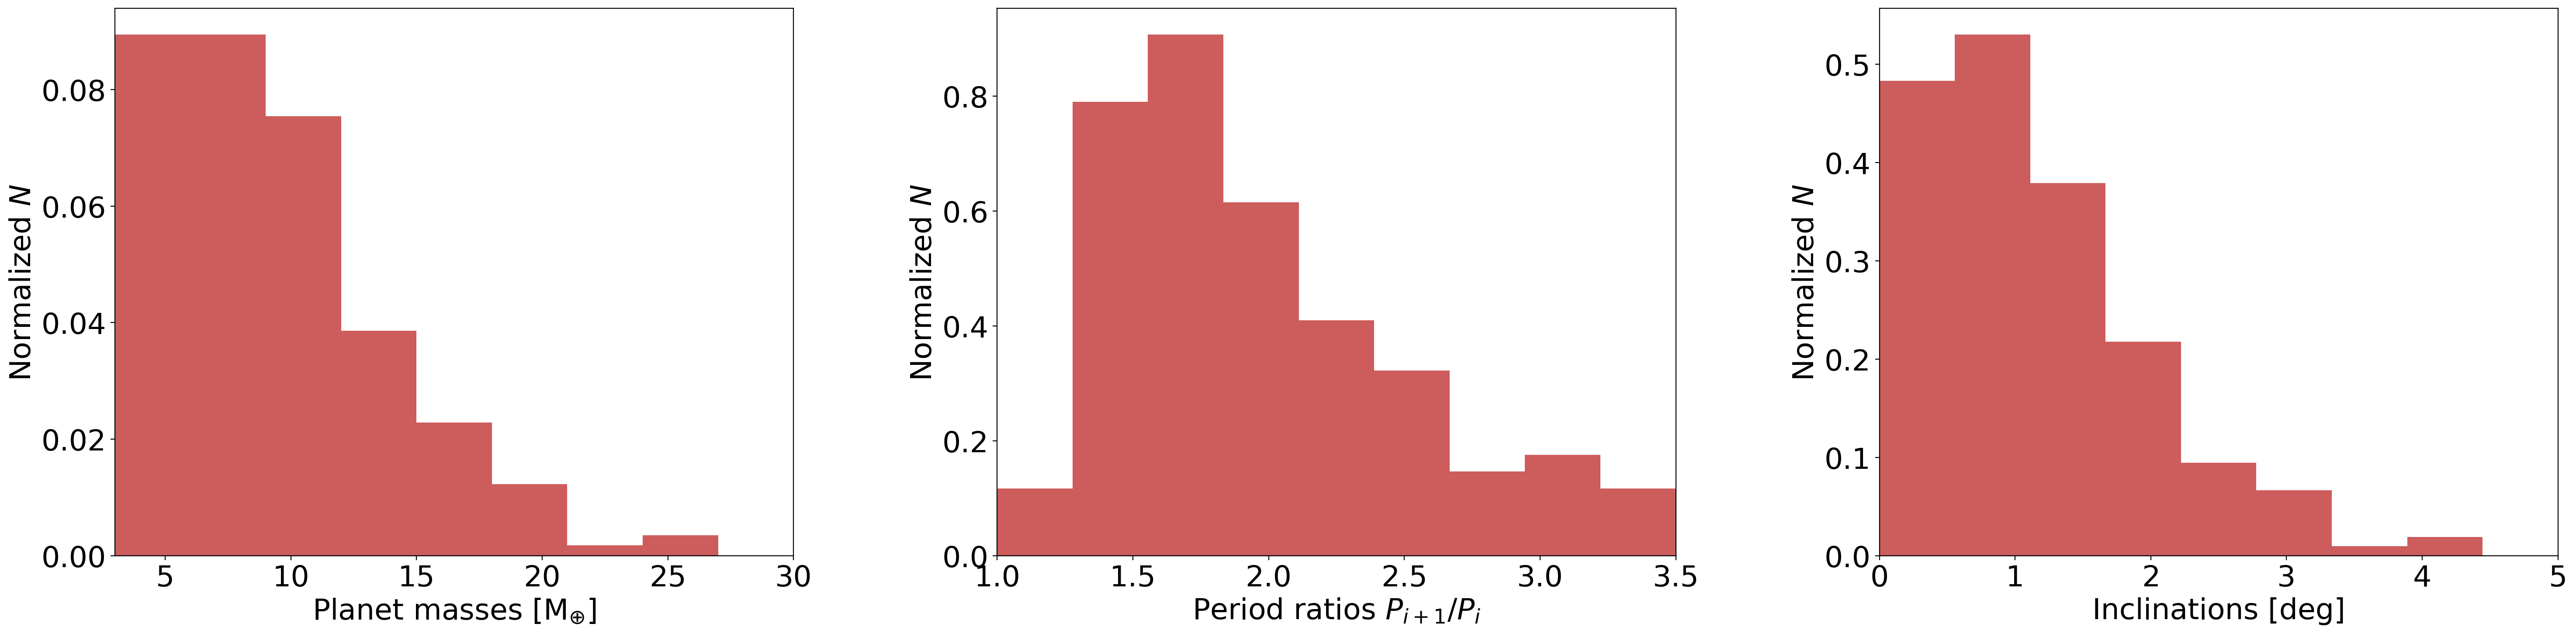

In [6]:
plt.rcParams['font.size'] = 24
fig, ax = plt.subplots(1, 3, figsize=(30.0,7.78), facecolor='white', dpi=200)
ax[0].hist(masses, bins=np.linspace(3.0, 30.0, 10), color='indianred', lw=0.0, density=True)
ax[0].set_xlabel(r'Planet masses [M$_{\oplus}$]')
ax[0].set_ylabel(r'Normalized $N$')
ax[0].set_xlim([3.0, 30.0])
ax[1].hist(period_ratios, bins=np.linspace(1.0, 3.5, 10), color='indianred', lw=0.0, density=True)
ax[1].set_xlabel(r'Period ratios $P_{i+1}/P_{i}$')
ax[1].set_ylabel(r'Normalized $N$')
ax[1].set_xlim([1.0, 3.5])
ax[2].hist(inclinations, bins=np.linspace(0.0, 5.0, 10), color='indianred', lw=0.0, density=True, label='True $N$-body (${\sim}\,500$\,hours)')
ax[2].set_xlabel(r'Inclinations [deg]')
ax[2].set_ylabel(r'Normalized $N$')
ax[2].set_xlim([0.0, 5.0])
plt.tight_layout()
fig.subplots_adjust(wspace=0.3)
plt.show()

The resulting planet properties look reasonable, and we find that they compare well with full N-body simulations (see Fig. 6 in the paper). Some natural extensions of this example include further analysis of the predicted system architectures (e.g., using other summary statistics) or exploring other possible initial conditions (e.g., non-equal mass, non-equally spaced bodies).